# Harris algorithm

В ходе выполнения лабораторной работы был реализован алгоритм детекции углов Харриса с применением CUDA.

**Входные данные:** 

*   изображение в градациях серого;
*   пороговое значение.

**Выходные данные:**

* время выполнения с использованием GPU;
* время выполнения без GPU;
* изображение, полученное в результате применения алгоритма (выводится и сохраняется в файл).

In [1]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [2]:
!nvidia-smi

Wed Jan  5 23:07:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
from numba import cuda
from time import time
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

Исходное изображение


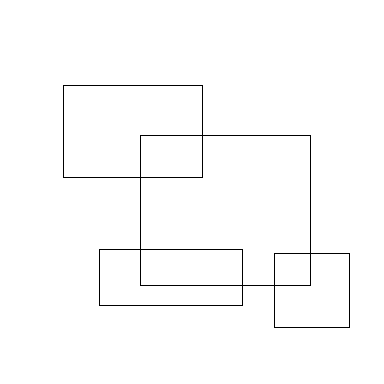

In [4]:
img_src = cv2.imread("/content/ex1.png")
im = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)
print("Исходное изображение")
cv2_imshow(img_src)

In [5]:
# пороговое значение
threshold = 10000.0

## Реализация на GPU

In [6]:
@cuda.jit
def harris_gpu(im, a, w, h):
  i, j = cuda.grid(2)
  # вычисляем используя оператор Собеля
  Ix = im[i-1][j-1]*-1 + im[i-1][j+1]*1 + im[i][j-1]*-2 + im[i][j+1]*2 + im[i+1][j-1]*-1 + im[i+1][j+1]*1
  Iy = im[i-1][j-1]*-1 + im[i-1][j]*-2 + im[i-1][j+1]*-1 + im[i+1][j-1]*1 + im[i+1][j]*2 + im[i+1][j+1]*1
  Ixx = Ix ** 2
  Iyy = Iy ** 2
  Ixy = Ix * Iy
  detA = Ixx * Iyy
  traceA = Ixx + Iyy 
  a[i][j] = detA - 0.05 * traceA ** 2

Harris GPU
time: 0.0011286735534667969


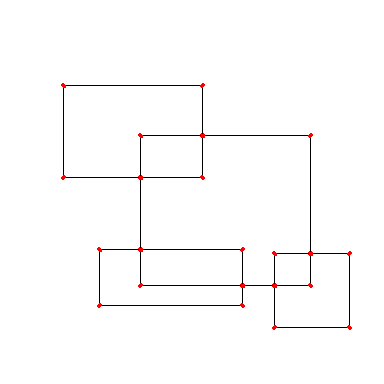

In [10]:
print('Harris GPU')

img_array = np.array(im)

# ширина и высота изображения
w = img_array.shape[0]
h = img_array.shape[1]

# массив под результат
a = np.zeros((w, h), dtype=np.int16)

a_global = cuda.to_device(a)
im_global = cuda.to_device(im)
w_global = cuda.to_device(w)
h_global = cuda.to_device(h)

block = (32, 32)
grid = (w // block[0], h // block[1])

start = time()
harris_gpu[grid, block](im_global, a_global, w_global, h_global)
time_gpu = time() - start

mark = a_global.copy_to_host()
image = img_src.copy()

for j in range(0, h - 1):
    for i in range(0, w - 1):
        value = mark[j, i]
        if value > threshold:
            cv2.circle(image, (i, j), 1, (0, 0, 255))

print('time:', time_gpu)
cv2.imwrite('gpu_result.png', image)
cv2_imshow(image)

## Реализация на CPU

Harris CPU
time: 0.007996797561645508


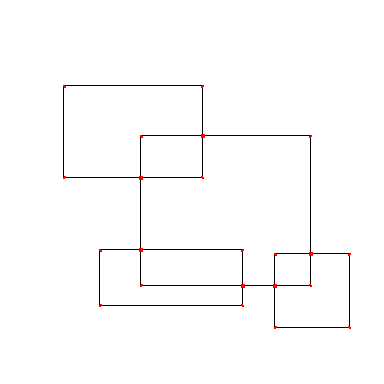

In [11]:
print('Harris CPU')

gray = np.float32(im)

start = time()
dst = cv2.cornerHarris(gray, 2, 3, 0.05)
time_cpu = time() - start
print('time:', time_cpu)

img_src[dst > 0.01 * dst.max()] = [0, 0, 255]

cv2.imwrite('cpu_result.png', img_src)
cv2_imshow(img_src)

In [12]:
print('Ускорение: ', time_cpu / time_gpu)

Ускорение:  7.085128855090832


Таким образом, распараллеливание алгоритма Харриса с помощью CUDA позволило в несколько раз повысить скорость обнаружения углов на изображении.